# Using Neural Network Formulations in OMLT

In this example we show how different neural networks can be formulated using Pyomo and OMLT. This notebook assumes you have a working tensorflow environment in addition to other necessary packages denoted below.

## Library Setup 1
Start by importing the libraries used in this project:

Base libraries used this project: <br>
`numpy`, `pandas`: data manipulation <br>
`json`: needed to write neural network parameters (e.g. scaling information) <br>
`matplotlib`: used for plotting the results in this example


In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

## Library Setup 2
OMLT extends Pyomo blocks and provides capabilities to use Keras neural networks. In this example we use Pyomo to setup an optimization problem and we use Keras (through tensorflow) to train a simple neural network.
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `tensorflow`: the machine learning language we use to train our neural network

In [3]:
import pyomo.environ as pyo
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

## Library Setup 3
We import the following classes from OMLT:
 - `OmltBlock`: A Pyomo custom block that can represent machine learning models (such as neural networks)

In [29]:
from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, NeuralNetworkFormulation, ComplementarityReLUActivation
from omlt.io import keras_reader
import omlt

## Import the Data

For demonstration purposes, we trained a neural network that learned a simple sin wave function given by:<br>
$$
y=sin(\omega x) + x^2
$$
on the interval $x \in [-2,2]$

In [11]:
df = pd.read_csv("../data/sin_quadratic.csv",index_col=[0])
df

,x,y
0,-2.0000,4.544021
1,-1.9996,4.540742
2,-1.9992,4.537460
3,-1.9988,4.534177
4,-1.9984,4.530892
...,...,...
9995,1.9984,3.456311
9996,1.9988,3.456225
9997,1.9992,3.456140
9998,1.9996,3.456058


The training data captures the function of interest and is plotted below (on the left). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the true values (on the right).

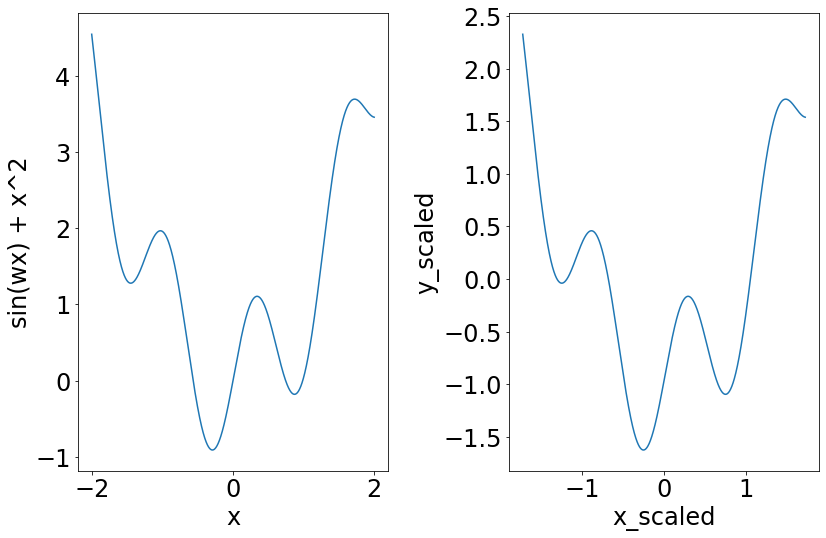

In [15]:
x = df["x"]
y = df["y"]

mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

f, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("sin(wx) + x^2");


ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled");

plt.tight_layout()

## Train the Neural Network
After producing our simple dataset, we use keras and tensorflow to train two neural networks to represent the quadratic sin curve. 

In [18]:
#relu neural network
model1 = Sequential(name='sin_wave_relu')
model1.add(Input(1))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer=Adam(), loss='mse')

#sigmoid neural network
model2 = Sequential(name='sin_wave_sigmoid')
model2.add(Input(1))
model2.add(Dense(100, activation='sigmoid'))
model2.add(Dense(100, activation='sigmoid'))
model2.add(Dense(100, activation='sigmoid'))
model2.add(Dense(1))
model2.compile(optimizer=Adam(), loss='mse')

In [19]:
history1 = model1.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=10)
history2 = model2.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=20)

Epoch 1/10
313/313 [==============================] - 0s 1ms/step - loss: 0.2050
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0770
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0700
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0641
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0443
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 5.4788e-04
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 4.6068e-04
Epoch 9/10
313/313 [==============================] - 1s 2ms/step - loss: 1.0017e-04
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 6.4547e-04: 0s - lo
Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 1.0076
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 0.9612
Ep

## Check the predictions

In [22]:
y_predict_scaled_relu = model1.predict(x=df['x_scaled'])
y_predict_relu = y_predict_scaled_relu*(std_data['y']) + mean_data['y']

y_predict_scaled_sigmoid = model2.predict(x=df['x_scaled'])
y_predict_sigmoid = y_predict_scaled_sigmoid*(std_data['y']) + mean_data['y']

### We load the neural network from Keras and show a decent fit to our simple sin curve

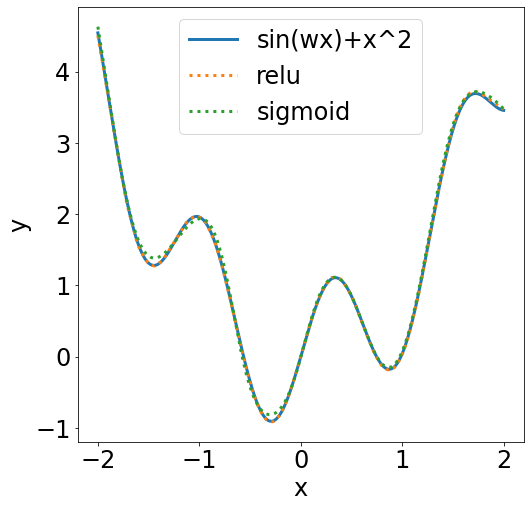

In [24]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "sin(wx)+x^2")
ax.plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",label = "relu")
ax.plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",label = "sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

## Formulating the OMLT Model
We now show OMLT can be used to optimize over neural networks. We show how to formulate the keras model into `OmltBlock`s and how to formulate different optimization representations.

In [30]:
model = pyo.ConcreteModel()
model.nn = OmltBlock()
model.x = pyo.Var()
model.y = pyo.Var()

In [32]:
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

input_bounds=[(min(df['x'])),max(df['x'])]

print(scaler)
print(input_bounds)

[-2.0, 2.0]


In [33]:
net = keras_reader.load_keras_sequential(model1,scaler,input_bounds)
print(net)

n_inputs: 1
NetworkDefinition(num_layers=5)


In [35]:
net.scaler = scaler
print(net.scaler)
print(net.input_bounds)

[-2.0, 2.0]


In [36]:
list(net.layers)

[<InputLayer(input_size=[1], output_size=[1]) at 0x7f596260a450>,
 <DenseLayer(input_size=[1], output_size=[100]) at 0x7f5952b684d0>,
 <DenseLayer(input_size=[100], output_size=[100]) at 0x7f59580cfe90>,
 <DenseLayer(input_size=[100], output_size=[100]) at 0x7f59580cfcd0>,
 <DenseLayer(input_size=[100], output_size=[1]) at 0x7f59580cf350>]

Multiple neural network formulations are possible. These include: <br>
`FullSpaceContinuousFormulation`<br> 
`ReducedSpaceContinuousFormulation`<br> 
`ReLUBigMFormulation` <br> 
`ReLUComplementarityFormulation`

## FullSpaceContinuousFormulation 
### TODO: write out what this formulation is

In [37]:
#hides the intermediate variables from the optimizer
formulation = NeuralNetworkFormulation(net,activation_constraints={
            "relu": ComplementarityReLUActivation()})

#formulation = ReducedSpaceContinuousFormulation(net)

#build the formulation on the OMLT block

model.nn.build_formulation(formulation)

#query inputs and outputs, as well as scaled inputs and outputs
#model.nn.inputs_list
#model.nn.outputs_list
#model.nn.scaled_inputs_list
#model.nn.scaled_outputs_list

TypeError: 'float' object is not subscriptable

### Solving the Pyomo Model
Now we solve an inverse problem over the neural network to find an input that produces the desired output <br>
$\min (\hat{y} - p)^2$ <br>
$s.t. \hat{y} = N(x)$

In [ ]:
model.obj = pyo.Objective(expr=(model.output - 0.5)**2)
status = pyo.SolverFactory('ipopt').solve(model, tee=False)
print(pyo.value(model.input))
print(pyo.value(model.output))

In [38]:
formulation = FullSpaceContinuousFormulation(net)

NameError: name 'FullSpaceContinuousFormulation' is not defined

In [ ]:
formulation = ReLUBigMFormulation(net)

In [65]:
formulation = ReLUComplementarityFormulation(net)

NameError: name 'ReLUComplementarityFormulation' is not defined

## FullSpaceContinuousFormulation 
### TODO: write out what this formulation is

